# 1. Setup

Seção para realizar a prepração do ambiente de desenvolvimento, realizando a conexão com o Google Drive e importando as bibliotecas necessárias.



In [1]:
# Montagem do drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install googletrans==4.0.0-rc1 textblob nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=35e6e10168647f09e941cab0c78a5eb671f50d0a641f275b6dbfe47c897019b4
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:


In [3]:
# Importar bibliotecas
import time
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from googletrans import Translator
import random
import nltk
from nltk.corpus import wordnet

import unittest
from unittest.mock import patch

In [4]:
# Baixar dados do NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 2. Carregamento e Preparação dos Dados

Nesta seção é feito o carregamento da base de dados que está salva no drive compartilhado da turma, e fazendo todo o pré processamento dos dados, como separar em treino e teste, tokenizar, normalizar os paddings para utilizar no modelo com Embedding e transformando para número as intenções.



## 2.1 Carregamento de dados

In [5]:
# Carregar os dados
PATH = '/content/drive/Shareddrives/Grupo_05/baseTratada_v3_20240909.xlsx'
data = pd.read_excel(PATH)

In [6]:
# Carregar os dados que tinham poucos gerados pelo GPT
PATH2 = '/content/drive/Shareddrives/Grupo_05/DadosGeradosGPT_20240918_v2.xlsx'
dataGPT = pd.read_excel(PATH2)

In [ ]:
# Exibir as primeiras linhas do dataset
data = data[['Intencao', 'Pergunta_Lematizada', 'Resposta_Lematizada']]
data.head()

,Intencao,Pergunta_Lematizada,Resposta_Lematizada
0,Como depositar,dia gostar caixa family mart verde eh hora tra...,dia senhor utilizar carto depsito mquino hora ...
1,Como fazer remessa,enviar dinheiro japo,inscrever servio remessar baixe aplicativo bra...
2,Tempo de remessa,levar beneficirio receber dinheiro,via regro remessa sero pago ver pix hora dado ...
3,"Pedido de envio via metodo ""ByPhone""",acabar transferncia total iene,ir processar solicitacao otimo
4,"Pedido de envio via metodo ""ByPhone""",poder remesso iene iene caixa econmic...,ir processar solicitacao otimo


In [ ]:
data.head()

,Intencao,Pergunta_Lematizada,Resposta_Lematizada
0,Como depositar,dia gostar caixa family mart verde eh hora tra...,dia senhor utilizar carto depsito mquino hora ...
1,Como fazer remessa,enviar dinheiro japo,inscrever servio remessar baixe aplicativo bra...
2,Tempo de remessa,levar beneficirio receber dinheiro,via regro remessa sero pago ver pix hora dado ...
3,"Pedido de envio via metodo ""ByPhone""",acabar transferncia total iene,ir processar solicitacao otimo
4,"Pedido de envio via metodo ""ByPhone""",poder remesso iene iene caixa econmic...,ir processar solicitacao otimo


## 2.2 Preparação dos dados


In [ ]:
# Junção das colunas de perguntas e resposta para treinamento do modelo
perguntas = data[['Intencao', 'Pergunta_Lematizada']].copy()
respostas = data[['Intencao', 'Resposta_Lematizada']].copy()
perguntas = perguntas.rename(columns={'Pergunta_Lematizada': 'Texto'})
respostas = respostas.rename(columns={'Resposta_Lematizada': 'Texto'})
base = pd.concat([perguntas,respostas])
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1564 entries, 0 to 781
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Intencao  1564 non-null   object
 1   Texto     1553 non-null   object
dtypes: object(2)
memory usage: 36.7+ KB


In [ ]:
base.value_counts('Intencao')

,count
Intencao,
Confirmacao de cambio/taxas,238
"Pedido de envio via metodo ""ByPhone""",200
Problemas/Duvidas de atualizacao de dados cadastrais,160
Problemas/Duvidas sobre remessas,130
Como se inscrever,118
Problemas/Duvidas sobre deposito,96
Tempo de remessa,82
Solicitacao de cartao de remessas,70
Termos e condicoes do servico,66


In [ ]:
# Substituir "Regras do servico" por "Termos e condicoes do servico" na coluna 'Intencao'
base['Intencao'] = base['Intencao'].replace('Regras do servico', 'Termos e condicoes do servico')

In [ ]:
# Merge das bases para iniciar o augmentation
base = pd.concat([base, dataGPT])
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1651 entries, 0 to 86
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Intencao  1651 non-null   object
 1   Texto     1640 non-null   object
dtypes: object(2)
memory usage: 38.7+ KB


## 2.3 Visualização

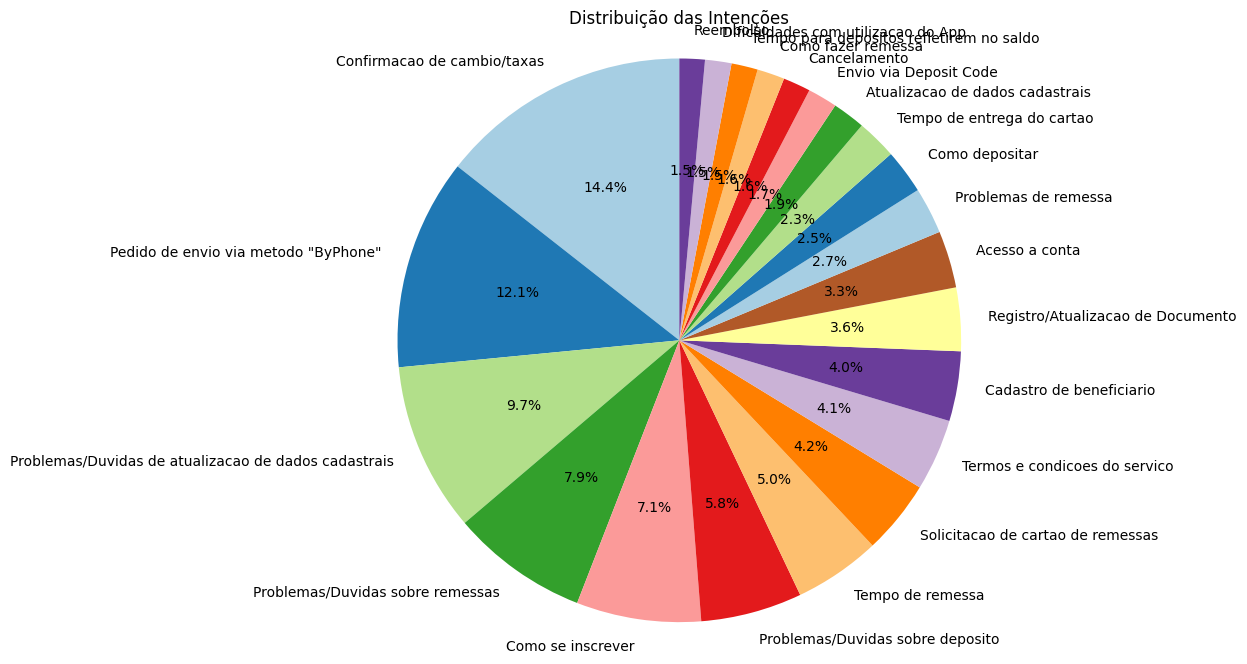

In [ ]:
# Visualização da base
baseVisual = base.copy()

# Contar a frequência de cada label
label_counts = baseVisual['Intencao'].value_counts()

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribuição das Intenções')
plt.axis('equal')  # Equal aspect ratio para que o gráfico seja desenhado como um círculo.
plt.show()


A partir da análise da imagem acima, observa-se que os dados estão desbalanceados, com algumas classes sub-representadas. Isso evidencia a necessidade de aplicar técnicas de aumento de dados (augmentation) nas classes com menor quantidade, a fim de evitar que o modelo seja enviesado e tenda a predizer predominantemente as classes principais, que apresentam maior probabilidade de acerto.

# 3. Augmentation

## 3.1 Preparação do Augmentation

Nesta seção será feita a preparação do augmentation instanciando as classes necessárias como Translator, e filtrando as intenções que possuem um número menor que 200

In [ ]:
# Contagem de ocorrências de cada intenção
intent_counts = base['Intencao'].value_counts()

# Definir as intenções que possuem menos de 200 ocorrências
intentions_to_augment = intent_counts[intent_counts < 200].index.tolist()

# Traduzir e reverter a tradução para gerar novas variações
translator = Translator()

In [ ]:
# Retirar valores iguais da coluna Texto
base = base.dropna(subset=['Texto'])

In [ ]:
# Visualização da base antes do augmentation
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1640 entries, 0 to 86
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Intencao  1640 non-null   object
 1   Texto     1640 non-null   object
dtypes: object(2)
memory usage: 38.4+ KB


## 3.2 Funções Augmentation

Nesta seção foi realizada três funções que irão fazer o augmentation da base de dados com o intuito de diversificar as intenções, sendo elas:

* translate_back: Irá traduzir as frases para o inglês e traduzir de volta para o português;

* replace_with_synonyms: Substituir as palavras por sinônimos

* shuffle_sentence: Embaralhar a sentença de forma que perca o contexto, porém haja a variação da base

In [7]:
def translate_back(text):
    try:
        # Tradução para outro idioma (ex: 'es' para espanhol)
        translated = translator.translate(text, dest='en').text
        # Reversão para o idioma original (ex: 'pt' para português)
        return translator.translate(translated, dest='pt').text
    except Exception as e:
        print(f"Erro na tradução: {e}")
        return text

# Função para substituir uma palavra por um sinônimo
def replace_with_synonyms(text):
    words = text.split()
    new_sentence = []
    for word in words:
        # Procurar sinônimos
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Escolher um sinônimo aleatório
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_sentence.append(synonym)
        else:
            new_sentence.append(word)
    return ' '.join(new_sentence)

# Função para trocar a ordem das palavras na frase
def shuffle_sentence(text):
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

## 3.3 Augmentation

Realização do data augmentation de forma aleatória, para não enviesar a base, sendo a função e o texto que será augmentado escolhido aleatóriamente.

In [ ]:
# Contagem de ocorrências de cada intenção
intent_counts = base['Intencao'].value_counts()

# Definir as intenções que possuem menos de 200 ocorrências
intentions_to_augment = intent_counts[intent_counts < 200].index.tolist()

# Aumentar o dataset com novas variações das intenções até que todas tenham 200 exemplos
augmented_data = []

for intent in intentions_to_augment:
    # Filtrar o DataFrame original para a intenção atual
    intent_texts = base[base['Intencao'] == intent]['Texto'].tolist()
    current_count = len(intent_texts)
    needed_augmentations = 200 - current_count  # Quantidade de exemplos que precisamos gerar

    while current_count < 200:
        original_text = random.choice(intent_texts)  # Escolhe uma frase original aleatoriamente
        augmentation_method = random.choice(['translate', 'synonym', 'shuffle'])

        if augmentation_method == 'translate':
            augmented_text = translate_back(original_text)
        elif augmentation_method == 'synonym':
            augmented_text = replace_with_synonyms(original_text)
        else:
            augmented_text = shuffle_sentence(original_text)

        # Adicionar o texto aumentado com a intenção original
        augmented_data.append({'Intencao': intent, 'Texto': augmented_text})
        current_count += 1

# 4. Resultados

## 4.1 Configuração dos resultados

In [ ]:
# Converter os dados aumentados para DataFrame
augmented_df = pd.DataFrame(augmented_data)

In [ ]:
# Retirar valores nulos e duplicados (Limpeza)
augmented_df = augmented_df.dropna(subset=['Texto'])
augmented_df = augmented_df.drop_duplicates(subset=['Texto'])

In [ ]:
# Informações da base augmentada
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2064 entries, 0 to 2795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Intencao  2064 non-null   object
 1   Texto     2064 non-null   object
dtypes: object(2)
memory usage: 48.4+ KB


In [ ]:
# Junção da base original com a augmentação
df = pd.concat([base, augmented_df])

In [ ]:
# Limpeza da base total
df = df.dropna(subset=['Texto'])
df = df.drop_duplicates(subset=['Texto'])

## 4.2 Visualização dos resultados

In [ ]:
df['Intencao'].value_counts()

,count
Intencao,
Confirmacao de cambio/taxas,218
Cadastro de beneficiario,154
Solicitacao de cartao de remessas,153
Termos e condicoes do servico,152
Acesso a conta,145
Problemas de remessa,140
Registro/Atualizacao de Documento,134
Como depositar,134
Tempo de remessa,134


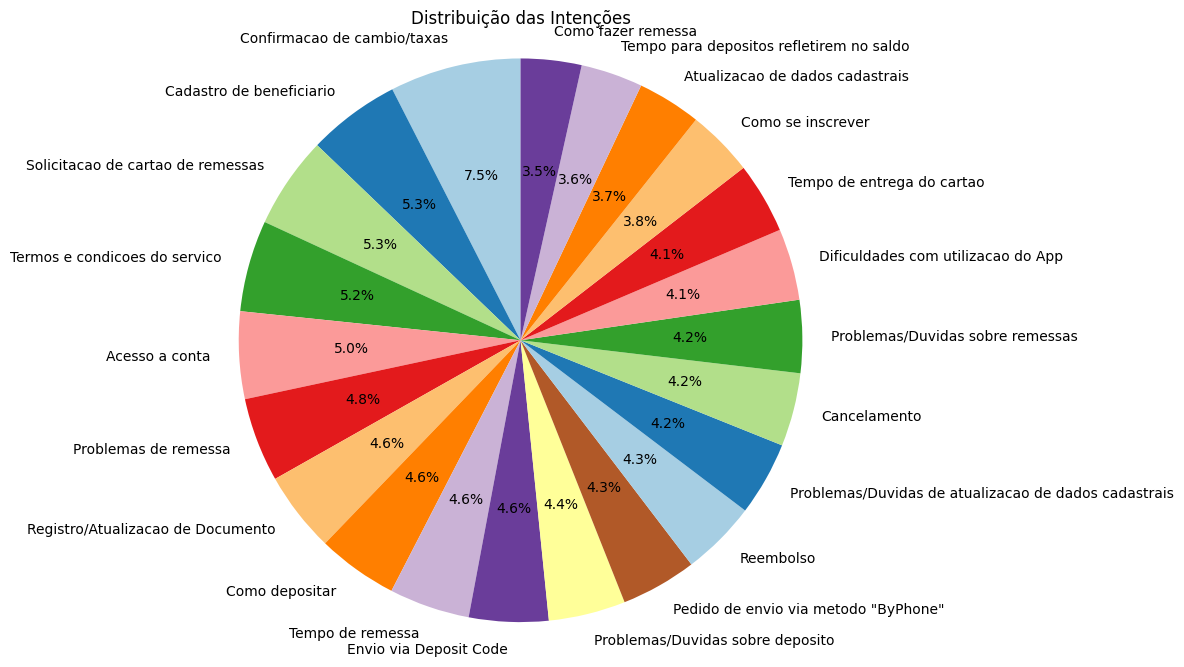

In [ ]:
# Contar a frequência de cada label
label_counts = df['Intencao'].value_counts()

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribuição das Intenções')
plt.axis('equal')  # Equal aspect ratio para que o gráfico seja desenhado como um círculo.
plt.show()


A partir dos resultados, percebe-se que aconteceu um balanceamento das classes, apesar de que existem classes dominantes elas já não são tão representativas, tendo uma diferença máxima entre a menor e maior classe de 4%. Enquanto a maioria das classes possuem 4%, apresentando uma melhora da base de dados.

## 4.3 Exportar resultados

In [ ]:
df.to_excel('/content/drive/Shareddrives/Grupo_05/base_aug_20240918_v1.xlsx')

# 5. Testes das funções do Augmentation

Os testes unitários visam verificar o funcionamento correto das funções translate_back, replace_with_synonyms e shuffle_sentence, responsáveis por transformar textos. A função translate_back traduz o texto para inglês e, em seguida, reverte para o português, garantindo que a tradução se mantenha correta. No teste, usamos um tradutor simulado para garantir que a função traduza e reverta como esperado. A função replace_with_synonyms substitui palavras por sinônimos, quando disponíveis. O teste simula a escolha de sinônimos para garantir que a substituição ocorra corretamente e que palavras sem sinônimos não sejam alteradas. Já a função shuffle_sentence embaralha as palavras de uma frase. O teste garante que a ordem das palavras seja alterada e que nenhuma palavra seja perdida, comparando as listas de palavras da frase original e da frase embaralhada. Esses testes verificam se as funções estão funcionando corretamente e de forma previsível.


## 5.1 Criação de dados artificiais

In [11]:
# Mock de dados para testar se está funcionando corretamente
class MockTranslator:
    def translate(self, text, dest):
        translations = {
            ('Hello', 'en'): 'Hello',
            ('Hello', 'pt'): 'Olá',
            ('Olá', 'en'): 'Hello',
            ('Texto', 'en'): 'Text',
            ('Text', 'pt'): 'Texto'
        }
        return type('obj', (object,), {'text': translations.get((text, dest), text)})

class MockWordNet:
    def synsets(self, word):
        synonyms = {
            'text': ['content', 'document'],
            'hello': ['hi', 'greetings']
        }
        if word in synonyms:
            return [type('obj', (object,), {'lemmas': lambda: [type('obj', (object,), {'name': lambda: synonym}) for synonym in synonyms[word]]})]
        return []

## 5.2 Instanciando classe dos dados

In [ ]:
# Testes mockados
translator = MockTranslator()
wordnet = MockWordNet()

## 5.3 Teste unitário das funções

In [13]:
# Unit test class
class TestTextAugmentation(unittest.TestCase):

    @patch('random.choice', lambda x: x[0])
    def test_translate_back(self):
        self.assertEqual(translate_back('Olá'), 'Olá')
        self.assertEqual(translate_back('Texto'), 'Texto')
        self.assertEqual(translate_back('Hello'), 'Olá')

    @patch('random.choice', lambda x: x[0])
    def test_replace_with_synonyms(self):
        self.assertNotEqual(replace_with_synonyms('hello text'), 'hello text')
        self.assertEqual(replace_with_synonyms('no_synonym'), 'no_synonym')

    def test_shuffle_sentence(self):
        original_sentence = 'this is a test'
        shuffled_sentence = shuffle_sentence(original_sentence)
        self.assertNotEqual(shuffled_sentence, original_sentence)
        self.assertCountEqual(shuffled_sentence.split(), original_sentence.split())

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.031s

OK
